In [38]:
import torch
import numpy as np

In [39]:
# recorded temperature data, c - celsius, u - unknown
t_cel = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_cel = torch.tensor(t_cel)
t_u = torch.tensor(t_u)
t_un = 0.1 * t_u

# 自动计算梯度

#### 应用自动求导, 使用 grad 属性

requires_grad=True 将使系统跟踪params张量进行操作后产生的所有张量的系谱树, 它们对params的导数将自动填充为params张量的grad属性.

In [40]:
# use linear model
def model(t_u, w, b):
    return w * t_u + b

# use square loss function
def loss_fn(t_cel, t_est):
    sqr_dif = (t_est - t_cel)**2
    return sqr_dif.mean()

In [41]:
# initialize gradient-required parameters
params = torch.tensor([1., 0.], requires_grad=True)

t_est = model(t_u, *params)
loss = loss_fn(t_cel, t_est)

loss.backward()     # 调用backward()的是待导函数

params.grad     # 系统将进行反向遍历, 计算待导函数对requires_grad者的导数

tensor([4517.2969,   82.6000])

#### 每次迭代需要归零梯度

注意! 每次反向传播, 系统将把求得的导数**累加**在grad上. 为防止这种情况, 需要在每次迭代时明确地将梯度归零.

In [42]:
if params.grad is not None:
    params.grad.zero_()

#### 总代码

In [43]:
def training_loop(n_epochs, learning_rate, params, t_u, t_cel):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_est = model(t_u, *params)
        loss = loss_fn(t_cel, t_est)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0 or epoch == 1:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [44]:
training_loop(
    n_epochs = 2500,
    learning_rate = 3e-2,
    params = torch.tensor([1., 0.], requires_grad=True),
    t_u = t_un, t_cel = t_cel
)

Epoch 1, Loss 80.364342
Epoch 500, Loss 3.091884
Epoch 1000, Loss 2.928639
Epoch 1500, Loss 2.927653
Epoch 2000, Loss 2.927646
Epoch 2500, Loss 2.927647


tensor([  5.3677, -17.3046], requires_grad=True)

# 使用梯度下降优化器

In [45]:
import torch.optim as optim
# dir(optim)

params = torch.tensor([1., 0.], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_est = model(t_un, *params)
loss = loss_fn(t_cel, t_est)

optimizer.zero_grad()       # 一定要归零梯度!
loss.backward()

optimizer.step()        # 已修改params

params

tensor([1.7761, 0.1064], requires_grad=True)

In [46]:
def training_loop(n_epochs, optimizer, params, t_u, t_cel):
    for epoch in range(1, n_epochs + 1):
        t_est = model(t_u, *params)
        loss = loss_fn(t_cel, t_est)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 or epoch <= 3:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

params = torch.tensor([1., 0.], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 2500,
    optimizer = optimizer,
    params = params,
    t_u = t_un, t_cel = t_cel
)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134


tensor([  5.3236, -17.0549], requires_grad=True)

# 训练, 验证, 防止过拟合

#### 分割数据集

In [47]:
# 构造训练集和验证集的索引

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [48]:
# 构造训练集和验证集

train_t_u = t_u[train_indices]
train_t_cel = t_cel[train_indices]
val_t_u = t_u[val_indices]
val_t_cel = t_cel[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [50]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_cel, val_t_cel):
    for epoch in range(1, n_epochs + 1):
        train_t_est = model(train_t_u, *params)
        train_loss = loss_fn(train_t_cel, train_t_est)
        
        with torch.no_grad():
            val_t_est = model(val_t_u, *params)
            val_loss = loss_fn(val_t_cel, val_t_est)
            assert val_loss.requires_grad == False      # if not True then throw an error

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 or epoch <= 3:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}')
    return params

params = torch.tensor([1., 0.], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 10000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, val_t_u = val_t_un, train_t_cel = train_t_cel, val_t_cel = val_t_cel
)

Epoch 1, Training loss 94.8695, Validation loss 15.0912
Epoch 2, Training loss 41.5927, Validation loss 5.0624
Epoch 3, Training loss 33.5647, Validation loss 12.8680
Epoch 1000, Training loss 2.6418, Validation loss 9.3247
Epoch 2000, Training loss 2.1245, Validation loss 8.1789
Epoch 3000, Training loss 2.1155, Validation loss 8.0354
Epoch 4000, Training loss 2.1154, Validation loss 8.0166
Epoch 5000, Training loss 2.1154, Validation loss 8.0142
Epoch 6000, Training loss 2.1154, Validation loss 8.0140
Epoch 7000, Training loss 2.1154, Validation loss 8.0140
Epoch 8000, Training loss 2.1154, Validation loss 8.0140
Epoch 9000, Training loss 2.1154, Validation loss 8.0140
Epoch 10000, Training loss 2.1154, Validation loss 8.0140


tensor([  5.3679, -16.7959], requires_grad=True)

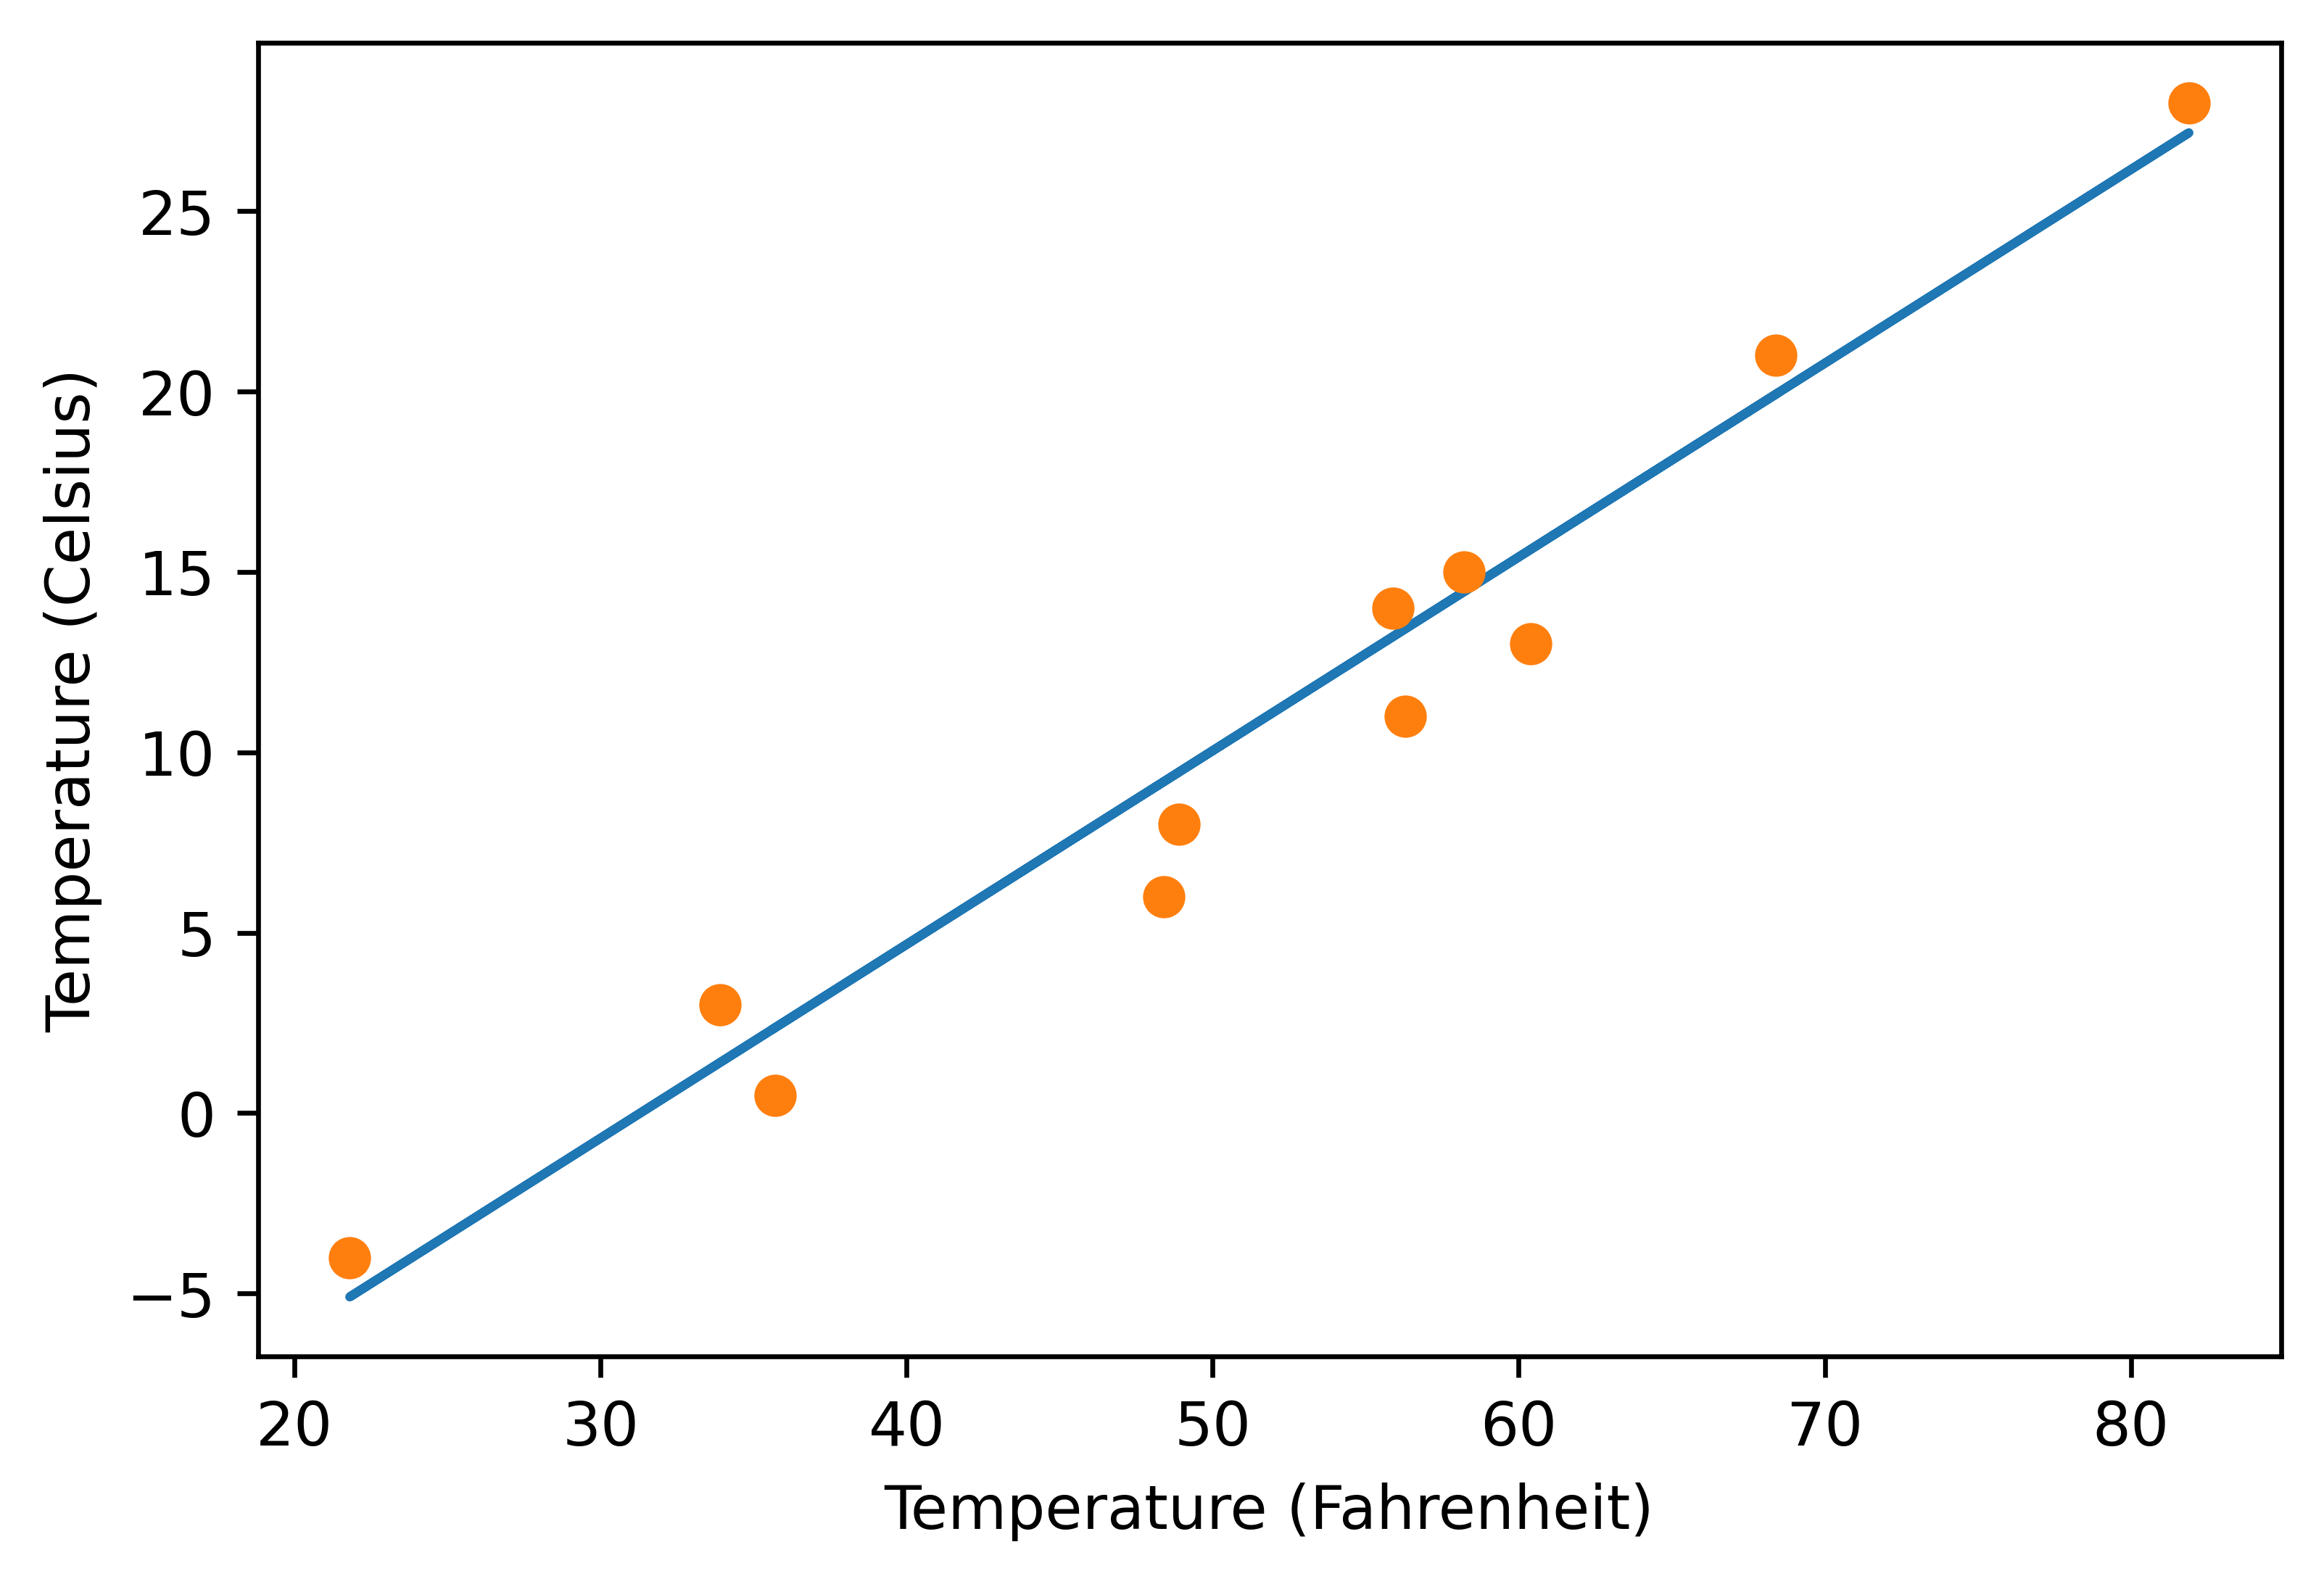

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)      # 技巧: 变量解包 *var 能分离出其内部的变量

fig = plt.figure(dpi=600)
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Temperature (Celsius)')
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_cel.numpy(), 'o')